In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import re
import pickle
from time import time
import collections
from keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from keras.models import Sequential,Model,load_model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
!ls

Archive.zip            archive (1)            glove.6B.50d.txt
Image captioning.ipynb flickr30k_images


In [3]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [4]:
captions = readTextFile("./archive (1)/captions.txt")
captions = captions.split('\n')[1:-1]

In [5]:
description ={}
for x in captions:
    first,second = x[:25],x[25:]
    img_name = first.split(".")[0]
    print(first,second)
    if description.get(img_name) is None:
        description[img_name]= []
    description[img_name].append(second)

1000268201_693b08cb0e.jpg ,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg ,A girl going into a wooden building .
1000268201_693b08cb0e.jpg ,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg ,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg ,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg ,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg ,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg ,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg ,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg ,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg ,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jp

1115679311_245eff2f4b.jpg ,A black dog runs along the beach and jumps over a wood barrior .
1115679311_245eff2f4b.jpg ,A dog is running on the beach .
1115679311_245eff2f4b.jpg ,a dog jumping over a small wall at a beach near the water .
1115679311_245eff2f4b.jpg ,An animal is running on the beach .
111766423_4522d36e56.jpg, A black and white bird eating seeds out of someone 's hand
111766423_4522d36e56.jpg, A black and white bird standing on a hand .
111766423_4522d36e56.jpg, A small bird sits in a person 's hand and eats seeds .
111766423_4522d36e56.jpg, Black and white bird standing on hand of someone holding sunflower seeds
111766423_4522d36e56.jpg, The small bird is clinging to a finger of the hand holding the seeds .
1117972841_2b9261f95f.jpg ,A brown dog is running in the sand .
1117972841_2b9261f95f.jpg ,A brown dog playing in the sand .
1117972841_2b9261f95f.jpg ,A brown dog plays at the beach .
1117972841_2b9261f95f.jpg ,A dog is standing in the sand .
1117972841_2b9261f95f.j

125319704_49ead3463c.jpg, Person standing beside bike in stream .
125319704_49ead3463c.jpg, Two bicyclists pose by a stream for a picture .
125319704_49ead3463c.jpg, two biker walk across the ground .
125319704_49ead3463c.jpg, Two off road bikers stopped in a creek .
125319704_49ead3463c.jpg, "Two people , in bike gear , stand with bicycles near a rocky waterbed ."
1253264731_e7c689eca5.jpg ,A girl in a coral shirt with glasses is smiling while leaning against a fence .
1253264731_e7c689eca5.jpg ,A girl wearing a pink shirt and overalls is smiling and there is another child that is out of focus .
1253264731_e7c689eca5.jpg ,Children playing in stopped motion
1253264731_e7c689eca5.jpg ,Two children are standing on a green metal fence .
1253264731_e7c689eca5.jpg ,"Two girls , one in overalls , holding on to a fence with water behind them ."
1253275679_e955fb7304.jpg ,A boy has his head down and is wearing a shirt that says ADHD .
1253275679_e955fb7304.jpg ,a young boy wearing a clever bla

132489044_3be606baf7.jpg, A tired business man takes a quick nap while riding the train .
132489044_3be606baf7.jpg, A young man in a suit and tie leans against a railing to take a nap on public transit .
1329832826_432538d331.jpg ,"People stand on a street corner at dusk , with a pharmacy in the background ."
1329832826_432538d331.jpg ,People stand outside of the Rite Aid pharmacy on Broadway .
1329832826_432538d331.jpg ,People waiting to cross the street in front of a pharmacy with lit up sign .
1329832826_432538d331.jpg ,Some people look to cross the street in front of a drug store .
1329832826_432538d331.jpg ,This is a picture of a Broadway Rite Aid Pharmacy that has a bright neon sign and people are prepared to cross the street in front of it .
1330645772_24f831ff8f.jpg ,A black and white dog is running in the grass .
1330645772_24f831ff8f.jpg ,A black dog is running across a low cut field nearby an area of trees .
1330645772_24f831ff8f.jpg ,a black dog runs through a field .
13306

1402640441_81978e32a9.jpg ,The little boy in red trunks is attempting to catch a soccer ball that is coming towards him .
1402640441_81978e32a9.jpg ,Young boy plays ball on the beach .
1402641725_5e027ecaa7.jpg ,Four children are playing on a hill of sand .
1402641725_5e027ecaa7.jpg ,Four children playing in the sand at a beach .
1402641725_5e027ecaa7.jpg ,Four children playing on a sand dune .
1402641725_5e027ecaa7.jpg ,Four kids are sliding down a mountain of sand .
1402641725_5e027ecaa7.jpg ,Four kids rolling and sliding down a sand dune .
1402843760_d30f1dbf0f.jpg ,a dog trots through the grass .
1402843760_d30f1dbf0f.jpg ,A fluffy white dog is outside .
1402843760_d30f1dbf0f.jpg ,A white dog competing in an agility event .
1402843760_d30f1dbf0f.jpg ,A white dog lifts its paw as it stands on the grass near striped poles .
1402843760_d30f1dbf0f.jpg ,The small furry white dog is walking in the green grass .
1402859872_0fc8cf8108.jpg ,A boy high-fives a mannequin .
1402859872_0fc8cf81

1461653394_8ab96aae63.jpg ,A white dog snarls at a black dog in front of a set of steps .
1461653394_8ab96aae63.jpg ,The black dog and the white dog seem to be getting ready to fight .
1461667284_041c8a2475.jpg ,A guitarist plays while people play with hula-hoops in the background .
1461667284_041c8a2475.jpg ,"A guitarist sits playing before microphones , while a man and a boy dance and a woman stands by ."
1461667284_041c8a2475.jpg ,A man in a white hat plays guitar on a stage .
1461667284_041c8a2475.jpg ,A man plays guitar on a stage while another woman smiles
1461667284_041c8a2475.jpg ,Four people performing music outdoors .
1463638541_c02cfa04dc.jpg ,A girl climbing a rope wall .
1463638541_c02cfa04dc.jpg ,A girl in a harness on a rope climbing wall .
1463638541_c02cfa04dc.jpg ,A girl is climbing up a rope ladder with a harness .
1463638541_c02cfa04dc.jpg ,A person is climbing and has nearly reached the sign at the top
1463638541_c02cfa04dc.jpg ,A young girl suspended by rope next 

1557838421_a33f2a4911.jpg ,There are two dogs playing with each other .
1557838421_a33f2a4911.jpg ,Two dogs wrestle with each other with their teeth bared .
1557838421_a33f2a4911.jpg ,Two large dogs attempt to bite each other playfully .
1561658940_a947f2446a.jpg ,A little girl in a swing laughs .
1561658940_a947f2446a.jpg ,A little girl is swinging in her brightly colored swing outside .
1561658940_a947f2446a.jpg ,A little girl sits in a plastic swing set .
1561658940_a947f2446a.jpg ,A young girl on a swing .
1561658940_a947f2446a.jpg ,Girl wearing pink pants smiles in baby swing
1562392511_522a26063b.jpg ,A dog chewing a blue rope while two men watch from behind .
1562392511_522a26063b.jpg ,Black dog with blue string in its mouth .
1562392511_522a26063b.jpg ,Two men handle a grey dog with a blue knotted rope in its mouth .
1562392511_522a26063b.jpg ,Two men lift a brown dog up so it can grab a large blue rope hanging down a black wall .
1562392511_522a26063b.jpg ,Two men under a dog 

1770036088_08abe4f6e9.jpg ,A woman and a small child laying in bed .
1770036088_08abe4f6e9.jpg ,The woman is laying in bed with a young girl .
1770036088_08abe4f6e9.jpg ,Two people are in bed .
1771490732_0ab5f029ac.jpg ,Three boys playing soccer in a field
1771490732_0ab5f029ac.jpg ,Three boys playing soccer .
1771490732_0ab5f029ac.jpg ,Two boys in blue and yellow uniforms play soccer with a boy in a pink printed uniform .
1771490732_0ab5f029ac.jpg ,Two teammates attempt to convert a soccer goal past the goalie .
1771490732_0ab5f029ac.jpg ,Uniformed children playing soccer
1772859261_236c09b861.jpg ,A black and white dog plays in the water .
1772859261_236c09b861.jpg ,A black and white dog walking in shallow water
1772859261_236c09b861.jpg ,A dog splashes through the water .
1772859261_236c09b861.jpg ,A dog swims .
1772859261_236c09b861.jpg ,Black and white dog wearing a harness walking through water .
177302997_5b2d770a0a.jpg, A child holding on to the bar while riding a horse on a c

1932314876_9cc46fd054.jpg ,A man wearing a blue shirt and shorts is resting on a rock soaking his feet in a rocky stream .
1932314876_9cc46fd054.jpg ,A person is sitting near smooth rocks on a stream bed .
1932314876_9cc46fd054.jpg ,"A woman dressed in a blue shirt , plaid shorts and brown shoes , soaking her feet in a rocky creek while sitting on a towel ."
1936215201_d03a75cbba.jpg ,A baby boy plays outside with a blue toy .
1936215201_d03a75cbba.jpg ,A baby carrying a ball in stands in front of a house with a hose in the background .
1936215201_d03a75cbba.jpg ,A little boy is holding a blue ball in the yard .
1936215201_d03a75cbba.jpg ,A male child holding a ball standing on the sidewalk .
1936215201_d03a75cbba.jpg ,a young boy playing with a blue ball standing on a sidewalk
1937104503_313d22a2d0.jpg ,A black and white dog is playing in water .
1937104503_313d22a2d0.jpg ,a black dog is standing on a step next to a river at it shakes itself dry .
1937104503_313d22a2d0.jpg ,A dog is s

2064780645_8f28a1529f.jpg ,Several people are standing near trees at dusk .
2064780645_8f28a1529f.jpg ,The setting sun outlines a group of four people and the surrounding trees .
2064780645_8f28a1529f.jpg ,The sun is setting behind a group of people .
2064790732_219e52e19c.jpg ,A boy without a shirt is running in the street while several people stand behind him .
2064790732_219e52e19c.jpg ,A little boy dances with a group of people behind him on a city street .
2064790732_219e52e19c.jpg ,A small boy dances on the concrete surrounded by adults .
2064790732_219e52e19c.jpg ,The little boy wearing no shirt is running by a crowd of people .
2064790732_219e52e19c.jpg ,The shirtless little boy is walking around adults .
2064792226_97e41d8167.jpg ,A girl is taking a picture of a girl and guy on a colorfully decorated pink bike .
2064792226_97e41d8167.jpg ,A girl sits on a decorated bike with a younger boy while another girl takes a picture .
2064792226_97e41d8167.jpg ,Two people on a bicycle a

2097407245_c798e0dcaf.jpg ,A man is standing on dirt with his hands in the air with mountains and snow behind him .
2097407245_c798e0dcaf.jpg ,A man raises his arms on rocky beach .
2097407245_c798e0dcaf.jpg ,One lone man with fist in the air with large rocky mountains in the background
2097407245_c798e0dcaf.jpg ,Man with outstretched arms standing on snow-covered rocks .
2097420505_439f63c863.jpg ,A male hiker wearing a green jacket is posing next to a large glacier .
2097420505_439f63c863.jpg ,A man with a camera and an ice structure behind him .
2097420505_439f63c863.jpg ,A man with a camera crouching on ice .
2097420505_439f63c863.jpg ,A man with a camera kneels in front of a giant hill of snow .
2097420505_439f63c863.jpg ,The mountain climber prepares to take a photo .
2097489021_ca1b9f5c3b.jpg ,A girl in a ballet fairy costume is touched by a wand .
2097489021_ca1b9f5c3b.jpg ,A young girl performing the nutcracker .
2097489021_ca1b9f5c3b.jpg ,The little girl is standing on a stag

2148991939_3b9fd6c439.jpg ,A black dog jumping into the water
2148991939_3b9fd6c439.jpg ,A black dog jumps off a pier into a lake .
2148991939_3b9fd6c439.jpg ,A dog leaps off a dock and into the water .
2148991939_3b9fd6c439.jpg ,The black dog leaps off the dock and into the water .
2149968397_a7411729d1.jpg ,A child is wading through water towards the beach .
2149968397_a7411729d1.jpg ,A small african boy leaves the ocean while many others continue to play behind him .
2149968397_a7411729d1.jpg ,A small black child playing in the ocean .
2149968397_a7411729d1.jpg ,A young boy wades in the ocean .
2149968397_a7411729d1.jpg ,A young boy walks in the water along a wavy shore .
2149982207_5345633bbf.jpg ,"A boy wearing a black and blue life vest is on a green , wooden boat looking out towards the water ."
2149982207_5345633bbf.jpg ,A boy wearing a blue life jacket is holding onto the side of a green boat .
2149982207_5345633bbf.jpg ,"A child holds on to the side of a small , weathered , g

219843859_94b6d0a580.jpg, A man climbs a sheer cliff face .
219843859_94b6d0a580.jpg, A man climbs a steep rock wall using safety ropes .
219843859_94b6d0a580.jpg, A man clings to the side of a rock face .
219843859_94b6d0a580.jpg, A man is rock climbing with no noticable harness .
219843860_332e5ca7d4.jpg, a climber is reaching for a large crack in the rock face .
219843860_332e5ca7d4.jpg, A man in a white t-shirt and blue shorts is rock climbing up a sheer face
219843860_332e5ca7d4.jpg, A man reaches high to help him during his rock climb .
219843860_332e5ca7d4.jpg, A man rock climbing
219843860_332e5ca7d4.jpg, A man with a white shirt climbing the side of a cliff .
2198484810_50a893824a.jpg ,A brown dog is running through an obstacle course .
2198484810_50a893824a.jpg ,A brown dog jumps over an obstacle .
2198484810_50a893824a.jpg ,A dog runs through an obstacle course .
2198484810_50a893824a.jpg ,A small dog jumping over hurdles .
2198484810_50a893824a.jpg ,The brown dog is jumping

2242863004_3a9f82a31f.jpg ,A dog with a red ball .
2242863004_3a9f82a31f.jpg ,A German shepherd is playing with a red ball .
2242863004_3a9f82a31f.jpg ,A German Shepherd is playing with a red ball .
2242863004_3a9f82a31f.jpg ,a German Sheppard dog bting a large red ball
224369028_b1ac40d1fa.jpg, A little blonde girl is standing in front of a water fountain .
224369028_b1ac40d1fa.jpg, a young blond girl standing in front of a large fenced in fountain
224369028_b1ac40d1fa.jpg, A young girl standing in front of a fountain
224369028_b1ac40d1fa.jpg, A young in a white dress standing in front of a fence and fountain .
224369028_b1ac40d1fa.jpg, The little girl in a white dress is standing in front of the large park fountain .
2243904502_2d265fed80.jpg ,A dog running with a toy in his mouth .
2243904502_2d265fed80.jpg ,A dog with a yellow toy in its mouth .
2243904502_2d265fed80.jpg ,A yellow dog running through a yard covered in leaves while holding a yellow toy in his mouth .
2243904502_2d26

2272967004_1531726d71.jpg ,A man with a snowboard sits atop a mountain looking at the view .
2272967004_1531726d71.jpg ,A person sitting atop a sandy mountainside staring into waterfalls .
2272967004_1531726d71.jpg ,a snowboarder leaning against his snowboard while looking at view of foggy mountains
2272967004_1531726d71.jpg ,A snowboarder sits on a mountain staring at a white foggy scenery .
2272967004_1531726d71.jpg ,The snowboarder gazes into the distance at some mountains .
2273028514_d7b584f73d.jpg ,A couple kiss in a subway station .
2273028514_d7b584f73d.jpg ,A couple quietly kisses in the dark .
2273028514_d7b584f73d.jpg ,A darkly lit scene of a man and woman kissing .
2273028514_d7b584f73d.jpg ,A man and woman kissing in a dark subway
2273028514_d7b584f73d.jpg ,A man in a leather jacket is kissing a girl in a subway station .
2273038287_3004a72a34.jpg ,A black dog is running very fast on a light brown ground .
2273038287_3004a72a34.jpg ,A dog runs outside .
2273038287_3004a72a

2302747917_aa0300eb68.jpg ,three children running barefooted in a gym
2302747917_aa0300eb68.jpg ,Three smiling children running indoors .
2303016989_0deb96c8d9.jpg ,A black and white dog is catching a red and green object in his mouth .
2303016989_0deb96c8d9.jpg ,A black and white dog is running through the field to catch something in its mouth .
2303016989_0deb96c8d9.jpg ,A dog catching a flexable Frisbee in its mouth .
2303016989_0deb96c8d9.jpg ,A small black and white dog jumps with an object in its mouth .
2303016989_0deb96c8d9.jpg ,The black and white dog leaps to catch a toy .
2303356248_65dd6aba6f.jpg ,Kids wearing jackets and hats swinging on tire swing in snow
2303356248_65dd6aba6f.jpg ,Two children swing in a tire in the snow at a park .
2303356248_65dd6aba6f.jpg ,Two children swing on a tire swing on a snowy day .
2303356248_65dd6aba6f.jpg ,Two kids in snow hats and blue and green coats are swinging on a tire swing out in the snow .
2303356248_65dd6aba6f.jpg ,Two young child

2333816000_7105d0ffac.jpg ,A man wearing a blue helmet is rock climbing .
2333816000_7105d0ffac.jpg ,A rock climber scaling a stone wall .
2333816000_7105d0ffac.jpg ,The man climbing the rock is wearing a blue helmet .
2335428699_4eba9b6245.jpg ,Children are playing on a trampoline in the snow .
2335428699_4eba9b6245.jpg ,Children jumping on a trampoline .
2335428699_4eba9b6245.jpg ,Five children jump on a large trampoline while the snow outside melts .
2335428699_4eba9b6245.jpg ,"Four children on a trampoline , in a snow covered area ."
2335428699_4eba9b6245.jpg ,Several children and jumping on a trampoline in the snow .
2335619125_2e2034f2c3.jpg ,A big black dog bares its teeth while running through the snow .
2335619125_2e2034f2c3.jpg ,A black dog is running through the snow .
2335619125_2e2034f2c3.jpg ,A black dog is running through the snow .
2335619125_2e2034f2c3.jpg ,A black dog with his mouth open and tongue out runs across an expanse of snow .
2335619125_2e2034f2c3.jpg ,Black 

2367317953_503317493e.jpg ,A female soccer player gives a teammate a piggyback ride .
2367317953_503317493e.jpg ,A woman carrying another woman wearing matching exercise attire on her back .
2367317953_503317493e.jpg ,The girl is hugging another girl outside .
2367317953_503317493e.jpg ,There is a girl in a Puma jacket being hugged from behind by another girl .
2367317953_503317493e.jpg ,Two athletic girls in PUMA outfits hugging each other .
2367318629_b60cf4c4b3.jpg ,a few small children drapped with black cloaks and black hats with red trim .
2367318629_b60cf4c4b3.jpg ,Five children dressed in black cloaks and hats .
2367318629_b60cf4c4b3.jpg ,five girls dressed alike
2367318629_b60cf4c4b3.jpg ,Four children in black and red hats and black clothes perform .
2367318629_b60cf4c4b3.jpg ,"Some children in black robes and black and red hats ,"
2367816288_7c2d11d3c5.jpg ,A boy cuts a flip in the grass .
2367816288_7c2d11d3c5.jpg ,A young man doing a flip on the grass .
2367816288_7c2d11d3

2405599120_ec5f32af6f.jpg ,A baby on a floor with an overturned basket and articles on the floor .
2405599120_ec5f32af6f.jpg ,A baby plays near an overturned basket of diapers .
2405599120_ec5f32af6f.jpg ,A toddler sits with diapers spread around the floor .
2405599120_ec5f32af6f.jpg ,a young baby sitting in the middle of the floor surrounded by clean diapers
240583223_e26e17ee96.jpg, A brown dog is running on a dirt path .
240583223_e26e17ee96.jpg, A dog is running down a dirt path .
240583223_e26e17ee96.jpg, A running golden retriever
240583223_e26e17ee96.jpg, A yellow dog running down a sandy path .
240583223_e26e17ee96.jpg, The yellow dog is running on the dirt road .
2405978603_6221b0c2e7.jpg ,A brown and white dog running into the water
2405978603_6221b0c2e7.jpg ,A brown and white dog running through water towards a toy .
2405978603_6221b0c2e7.jpg ,A brown dog is running into the ocean as it chases a purple Frisbee .
2405978603_6221b0c2e7.jpg ,A dog splashing in the water .
24059

2414397449_2ac3b78e0d.jpg ,A small dog lands on a big dog trying to get a disc .
2414397449_2ac3b78e0d.jpg ,A small white dogs leaps over the back of a larger dog to chase his toy .
2414397449_2ac3b78e0d.jpg ,Two dogs are playing in a field of tall grass .
2414397449_2ac3b78e0d.jpg ,White and black dog jumping over red haired dog in grass .
2414710960_a4cde4af60.jpg ,a black and white dog wearing a blue shirt carrying a toy in its mouth .
2414710960_a4cde4af60.jpg ,A brown dog with a blue suit on is playing with a toy over fake grass .
2414710960_a4cde4af60.jpg ,A dog in a blue sweater leaps while holding an object in its mouth .
2414710960_a4cde4af60.jpg ,A dog wearing a blue sweater holds a yellow toy in its mouth .
2414710960_a4cde4af60.jpg ,The black dog is wearing a blue jacket and playing with a toy .
2414986483_004936f84b.jpg ,A girl dances like a man in costume
2414986483_004936f84b.jpg ,A little girl and a man dancing .
2414986483_004936f84b.jpg ,A man in a black suit dances w

244443352_d7636e1253.jpg, A brown dog in a red collar is diving into the snow .
244443352_d7636e1253.jpg, A brown dog wearing a red collar diving into snow .
244443352_d7636e1253.jpg, A dog in the snow .
244443352_d7636e1253.jpg, A yellow dog with a red bandanna fallen through the crust of the snow .
2444741900_5cb3ef3e1d.jpg ,A bunch of people are standing or sitting in a snow valley .
2444741900_5cb3ef3e1d.jpg ,A number of people standing and laying under a mountain covered in snow .
2444741900_5cb3ef3e1d.jpg ,Sledding and skiing enthusiasts gather at a snowy rock formation .
2444741900_5cb3ef3e1d.jpg ,Snow skiers gather at the bottom of a snowy hill .
2444741900_5cb3ef3e1d.jpg ,Some people hanging out in the snow .
2444821454_22a346c996.jpg ,A black and white dog is in the grass with a red striped disk .
2444821454_22a346c996.jpg ,a black and white dog jumping in the grass after a Frisbee .
2444821454_22a346c996.jpg ,A black and white dog jumps in the air near a red Frisbee .
244482

2467821766_0510c9a2d1.jpg ,Four hikers hike on trail through snow .
2467821766_0510c9a2d1.jpg ,People walking in a line with backpacks are using a trail through the trees .
2467850190_07a74d89b7.jpg ,A dog and a person look under the shelf .
2467850190_07a74d89b7.jpg ,A dog and a woman bending over .
2467850190_07a74d89b7.jpg ,A woman and a dog both kneel with their heads down and butt in the air .
2467850190_07a74d89b7.jpg ,a woman and a dog both with the butts turned towards the camera
2467850190_07a74d89b7.jpg ,The backs of a woman and a dog .
2467853482_17009933e8.jpg ,A boy blowing bubbles .
2467853482_17009933e8.jpg ,A boy in a blue shirt blows bubbles .
2467853482_17009933e8.jpg ,A boy in blue is blowing bubbles .
2467853482_17009933e8.jpg ,A boy is blowing bubbles
2467853482_17009933e8.jpg ,A young boy wearing a blue shirt blows bubbles .
2467856402_0490413d38.jpg ,A big brother helps a little sister blow bubbles .
2467856402_0490413d38.jpg ,A boy helping a younger girl blow bu

2502354602_f4d6dcf42d.jpg ,"A formally dressed couple , she with her mouth open , stand next to each other ."
2502354602_f4d6dcf42d.jpg ,A groom and a bride with a strapless dress .
2502354602_f4d6dcf42d.jpg ,A man in a black suit knocks his head with his fist as he puts his arm around a woman in a white strapless dress .
2502782508_2c8211cd6b.jpg ,A man in a hat and sunglasses reads a book on a park bench .
2502782508_2c8211cd6b.jpg ,A man in c camouflage cap and jeans is sitting on a bench reading a book .
2502782508_2c8211cd6b.jpg ,A man is sitting on a bench and reading a book .
2502782508_2c8211cd6b.jpg ,A man on a park bench reads a novel .
2502782508_2c8211cd6b.jpg ,A man wearing a camouflage hat and sunglasses reading a book on a black metal bench .
2502835694_4fe121bbea.jpg ,A group of people are outside a brick building taking pictures .
2502835694_4fe121bbea.jpg ,A group of people gathered for a meeting .
2502835694_4fe121bbea.jpg ,A group of people sits outside a building .

2527163162_d0fb802992.jpg ,A young girl dressed in a uniform is holding a very long stick .
2527303359_6c3dc3f282.jpg ,A girl in a white dress on the beach .
2527303359_6c3dc3f282.jpg ,A girl in a white dress walks toward the water and away from white boots on a beach .
2527303359_6c3dc3f282.jpg ,A girl walking on a beach barefoot .
2527303359_6c3dc3f282.jpg ,A little girl in white leaves her boots behind as she walks in the sand .
2527303359_6c3dc3f282.jpg ,A woman in a white dress walks toward the water on a beach with white boots in the foreground .
2527713011_b0ec25aa54.jpg ,A black and white rally car takes the turn .
2527713011_b0ec25aa54.jpg ,A global group race car .
2527713011_b0ec25aa54.jpg ,The black and white race car is going fast around the track while fans watch nearby .
2527713011_b0ec25aa54.jpg ,The black and white race car is rounding the turn .
2527713011_b0ec25aa54.jpg ,The race car is speeding up the hill .
252802010_3d47bee500.jpg, A brown and white dog playing wi

2557507575_b247f145bc.jpg ,A golden dog runs through a field of tall grass .
2557507575_b247f145bc.jpg ,A lean dog playing in tall grass .
2557922709_24d2a9655a.jpg ,A blonde girl and two American flags
2557922709_24d2a9655a.jpg ,A girl in glasses is looking over two American flags near a wooded area .
2557922709_24d2a9655a.jpg ,A girl wearing glasses behind two American flags .
2557922709_24d2a9655a.jpg ,A girl with glasses next red white and blue flags .
2557922709_24d2a9655a.jpg ,A young girl with glasses sits and holds two American flags .
2557972410_6925fe695c.jpg ,A goalie is guarding the goal .
2557972410_6925fe695c.jpg ,Kids in helmets play hockey outside .
2557972410_6925fe695c.jpg ,Several players playing a game of hockey outside on the road .
2557972410_6925fe695c.jpg ,Some children play hockey outside .
2557972410_6925fe695c.jpg ,Two children play street hockey in front of a goal .
2558312618_13d362df66.jpg ,A brown dog is jumping through a field .
2558312618_13d362df66.jpg

2587017287_888c811b5a.jpg ,A soaking wet dog walks across a stream .
2587017287_888c811b5a.jpg ,a wet golden retriever is walking through a lake
2587106431_1cc0e719c6.jpg ,"Three boys , dressed in blue and orange , are smiling and using hand signals ."
2587106431_1cc0e719c6.jpg ,Three children are laughing and playing together
2587106431_1cc0e719c6.jpg ,Three young boys dressed in an orange and navy shirt are smiling and doing signs with their fingers .
2587106431_1cc0e719c6.jpg ,Three young boys flash signs with their hands and smile .
2587106431_1cc0e719c6.jpg ,Three young boys wearing school uniforms pose and smile for the camera .
2587696611_db0378710f.jpg ,A girl in a white dress runs down a country road .
2587696611_db0378710f.jpg ,a girl walks on a dirt street .
2587696611_db0378710f.jpg ,A little girl in a white dress and no shoes walks down a dirt road in America .
2587696611_db0378710f.jpg ,A woman in a white dress is walking along a long straight road .
2587696611_db0378710f

2616643090_4f2d2d1a44.jpg ,a baby sticking wheat grass into his mouth
2616643090_4f2d2d1a44.jpg ,A baby wearing green holds onto plants and puts them in its mouth .
2616643090_4f2d2d1a44.jpg ,Small child in green sweater with plant in mouth .
2616673985_fa4354cc53.jpg ,A woman dressed in black is striding outside on a grassy lawn with a leashed black and white dog while people in the background watch .
2616673985_fa4354cc53.jpg ,A woman in gray holding onto the black dog 's leash .
2616673985_fa4354cc53.jpg ,A woman marches with a pair of dogs .
2616673985_fa4354cc53.jpg ,"A woman showing a long haired , large black pedigree dog at a dog show ."
2616673985_fa4354cc53.jpg ,A woman shows a dog with very long hair at a dog show .
261737543_b8fdc24671.jpg, A kid is jumping off the side of a mountain just outside a city .
261737543_b8fdc24671.jpg, A man jumping on a hill overlooking a town .
261737543_b8fdc24671.jpg, A man jumps off a cliff with a city view below .
261737543_b8fdc24671.jpg,

263854883_0f320c1562.jpg, Two yellow dogs run together in green grass .
2638981862_6b23833f37.jpg ,Two little boys in tuxedos .
2638981862_6b23833f37.jpg ,Two small boys dressed in tuxedos sitting on a red carpeted floor .
2638981862_6b23833f37.jpg ,Two young boys dressed in formal clothes fight while sitting on a red carpeted step .
2638981862_6b23833f37.jpg ,Two young boys in suits wrestle .
2638981862_6b23833f37.jpg ,Well dressed children play on the carpet .
2640000969_b5404a5143.jpg ,A big brown dog jumps into a swimming pool on the backyard .
2640000969_b5404a5143.jpg ,A dog in mid-leap into a pool .
2640000969_b5404a5143.jpg ,Brown dog jumping into the pool
2640000969_b5404a5143.jpg ,The brown dog is jumping into the crystal-clear pool .
2640000969_b5404a5143.jpg ,The large brown dog is jumping into a swimming pool .
2640153227_57cf1a3d92.jpg ,A little girl eating two cookies .
2640153227_57cf1a3d92.jpg ,A little girl with blonde hair and blue eyes is eating cookies .
2640153227

267325341_1a96ef436e.jpg, A dog running with a red item in its mouth .
267325341_1a96ef436e.jpg, Black dog running through grass with something orange in its mouth
267325341_1a96ef436e.jpg, "On garden lawn , black dog is retriving an object ."
2673564214_3a9598804f.jpg ,A young boy poses behind the netting of an enclosed play area while three other children play .
2673564214_3a9598804f.jpg ,Children playing in a green and blue bounce house .
2673564214_3a9598804f.jpg ,Children play in the blue and green jumping tent filled with air .
2673564214_3a9598804f.jpg ,Four children are playing on a bouncy castle .
2673564214_3a9598804f.jpg ,The little kids all play and jump around inside the inflatable toy .
2674784195_704f6b79d0.jpg ,Two boys are laying in the ocean close to the beach .
2674784195_704f6b79d0.jpg ,two boys playing in dirty water
2674784195_704f6b79d0.jpg ,Two children are playing in deep muddy water .
2674784195_704f6b79d0.jpg ,Two children are rolling in muddy water .
2674784

2700147489_f1664f2b61.jpg ,Man with beard doing skateboarding stunt
2700147489_f1664f2b61.jpg ,The guy in gray pants is completing a jump on his skateboard .
2701042060_92508ea8fa.jpg ,"A black dog is drinking next to a brown and white dog that is looking at an orange ball in the lake , whilst a horse and rider passes behind ."
2701042060_92508ea8fa.jpg ,A brown and white dog and a black dog near water with a man on horseback in the background
2701042060_92508ea8fa.jpg ,Dogs in the water with a basketball and a person on horseback .
2701042060_92508ea8fa.jpg ,Two dogs are playing near water next to a deflated basketball .
2701042060_92508ea8fa.jpg ,"Two dogs stand on sand surrounded by water , a deflated basketball and a person on a horse ."
2701271123_6761bc5f26.jpg ,A black dog is biting onto a soccer ball on the dirt ground .
2701271123_6761bc5f26.jpg ,A black dog walking in dirt has a soccer ball in his mouth .
2701271123_6761bc5f26.jpg ,A small dog with a soccer ball in its mouth 

2737233999_34d60dc5c3.jpg ,Four people playing basketball on wooden area near the beach .
2737233999_34d60dc5c3.jpg ,Kids playing basketball on a wood deck .
2737233999_34d60dc5c3.jpg ,Young children shoot baskets in the field .
2737609659_efce872c24.jpg ,A four wheel drive vehicle is driving on a dirt track .
2737609659_efce872c24.jpg ,A girl wearing camouflage pants sits on top of a Hummer .
2737609659_efce872c24.jpg ,Girl on roof of jeep being driven down road
2737609659_efce872c24.jpg ,"In rural outdoors , blond woman sits on roof of yellow BMW vehicle , two people inside ."
2737609659_efce872c24.jpg ,Two people drive a Jeep while a lady sits on the top of it .
2737729252_b3fd9c05b1.jpg ,A girl is taking a picture of another girl in a park .
2737729252_b3fd9c05b1.jpg ,A girl is taking a picture of another girl in a park .
2737729252_b3fd9c05b1.jpg ,A woman takes a picture of another in purple in a park .
2737729252_b3fd9c05b1.jpg ,one girl taking a picture of her friend
2737729252_

2760371526_63f3d01760.jpg ,A boy in goggles plays in a pool .
2760371526_63f3d01760.jpg ,a boy jumps into a pool .
2760371526_63f3d01760.jpg ,A boy makes a splash as he leaps into the swimming pool .
2760371526_63f3d01760.jpg ,A boy wearing goggles jumps into a blue swimming pool .
2760371526_63f3d01760.jpg ,Boy swimming in blue pool .
2760715910_87c7bdeb87.jpg ,A man walking while holding a hat on a stick .
2760715910_87c7bdeb87.jpg ,An Asian man balancing a hat on a stick
2760715910_87c7bdeb87.jpg ,A person holds a very small umbrella .
2760715910_87c7bdeb87.jpg ,Older man holds a baseball hat above his head with a pole .
2760715910_87c7bdeb87.jpg ,The man in the glasses holds something on a stick .
2760716468_b541e9fd0f.jpg ,A man sits on a step with two duffel bags and a plastic bag by his sides .
2760716468_b541e9fd0f.jpg ,A man wearing sandals sits on the sidewalk near some bags .
2760716468_b541e9fd0f.jpg ,"Bald , older man sits in gray stone area with bags , clapping hands ."
2

2796801478_8ebd7e550b.jpg ,A man rides his skateboard with his shadow falling on a wall covered in graffiti .
2796801478_8ebd7e550b.jpg ,A skateboarder grinding a lip .
2796801478_8ebd7e550b.jpg ,A skateboarder is jumping through the air in front of a graffiti covered wall .
2796801478_8ebd7e550b.jpg ,A skateboarder performs a skateboard trick against a graffiti wall .
2796801478_8ebd7e550b.jpg ,A skateboarder performs tricks on a ramp in front of a wall with graffiti .
2797149878_bb8e27ecf9.jpg ,A blond boy in a dark hoodie is holding a fishing rod .
2797149878_bb8e27ecf9.jpg ,A boy on the beach casts a fishing pole in the water .
2797149878_bb8e27ecf9.jpg ,A little boy is holding a fishing rod .
2797149878_bb8e27ecf9.jpg ,A young boy wearing a black hoodie is holding a fishing pole .
2797149878_bb8e27ecf9.jpg ,A young male holding a fishing pole .
2797185895_4d9e1e9508.jpg ,A red boat is paddled down the rapids by two people .
2797185895_4d9e1e9508.jpg ,Two canooers paddle through so

2845246160_d0d1bbd6f0.jpg ,A man in a red sweatshirt and a hat is looking at his phone while another man in black walks closer to him down the sidewalk .
2845246160_d0d1bbd6f0.jpg ,A man in a red sweatshirt and a straw hat uses a cellphone .
2845246160_d0d1bbd6f0.jpg ,A man in a straw hat shades his phone while others walk on a busy sidewalk .
2845246160_d0d1bbd6f0.jpg ,"A man with a hat taking a photo with his camera , while a passerby looks annoyed ."
2845691057_d4ab89d889.jpg ,A blonde woman holds an umbrella over a race car driver .
2845691057_d4ab89d889.jpg ,A couple outside in the rain at a stockcar race that he is racing in .
2845691057_d4ab89d889.jpg ,A man is sitting in a race car near a woman with an umbrella .
2845691057_d4ab89d889.jpg ,A woman holding an umbrella over a person in a race car .
2845691057_d4ab89d889.jpg ,Lady holding umbrella over race car driver .
2845845721_d0bc113ff7.jpg ,A man in jeans is playing with a ball while a woman in jeans stands nearby looking aw

2860202109_97b2b22652.jpg ,a man with dreeds wearing large black sunglasses
2860202109_97b2b22652.jpg ,dark skinned man with sunglasses in a blue shirt
2860202109_97b2b22652.jpg ,The man wearing a blue shirt has dreadlocks and sunglasses .
2860372882_e0ef4131d4.jpg ,A man in bright orange shorts is skateboarding along a course with cones as two people observe in the background .
2860372882_e0ef4131d4.jpg ,A man in orange shorts and knee pads is in a blurry picture .
2860372882_e0ef4131d4.jpg ,"A man in orange shorts , knee pads and a helmet , moves quickly on a street course ."
2860372882_e0ef4131d4.jpg ,a man in orange shorts moving really fast
2860372882_e0ef4131d4.jpg ,A skater goes through a course .
2860400846_2c1026a573.jpg ,a tan and white dog jumping after a red Frisbee .
2860400846_2c1026a573.jpg ,A white dog is running towards the red Frisbee on the grass .
2860400846_2c1026a573.jpg ,A white dog jumps above a red Frisbee that is rolling along the surface of a low cut field .


2893515010_4a3d9dcc67.jpg ,A football player carries the ball during a game .
2893515010_4a3d9dcc67.jpg ,A football player catches the ball as another tries to tackle him .
2893515010_4a3d9dcc67.jpg ,A football player in an orange jersey tries to escape with the ball from the tackler .
2893515010_4a3d9dcc67.jpg ,A football player is getting tackled .
2893515010_4a3d9dcc67.jpg ,The football player in the orange uniform has the ball in his arms .
2894008505_a445ccaaff.jpg ,"A woman is running along the side of a road , casting her shadow on a concrete wall ."
2894008505_a445ccaaff.jpg ,A woman jogs beside a tall concrete wall .
2894008505_a445ccaaff.jpg ,A woman runs beside a concrete wall .
2894008505_a445ccaaff.jpg ,Woman jogging beside the road .
2894008505_a445ccaaff.jpg ,Woman running on sidewalk
2894217628_f1a4153dca.jpg ,"A holder and kicker for a football team dressed in orange , white and black play while onlookers behind them watch ."
2894217628_f1a4153dca.jpg ,A kicker launche

2908859957_e96c33c1e0.jpg ,A girl in a yellow dress jump ropes .
2908859957_e96c33c1e0.jpg ,A girl skips rope .
2908859957_e96c33c1e0.jpg ,A girl wearing yellow jumps over a red and green rope .
2908859957_e96c33c1e0.jpg ,A little girl in a yellow dress jumping rope .
2908859957_e96c33c1e0.jpg ,The little girl in the yellow dress is jumping over a red and green rope .
2909081008_9a7bfc599a.jpg ,A guy is pointing with a girl sitting beside him .
2909081008_9a7bfc599a.jpg ,A man and a woman are smiling
2909081008_9a7bfc599a.jpg ,An Asian man and woman smile while the man points to something to the right of the picture .
2909081008_9a7bfc599a.jpg ,"There is an Asian man and woman , both smiling , and he is pointing at her ."
2909081008_9a7bfc599a.jpg ,two people laugh .
2909609550_070eea49b5.jpg ,A dog staring at the end of an ice cream cone .
2909609550_070eea49b5.jpg ,A shaggy white dog eyes the remaining part of an ice cream cone .
2909609550_070eea49b5.jpg ,A white shaggy dog wants a 

2949353587_64c54e9589.jpg ,A brown dog is chewing on a white rug whilst standing on a red carpet next to a checkered floor .
2949353587_64c54e9589.jpg ,A brown dog is playing with a white fluffy stuffed animal .
2949353587_64c54e9589.jpg ,A brown dog with a white covering in its mouth
2949353587_64c54e9589.jpg ,A dark brown dog chews on something white and fluffy .
2949353587_64c54e9589.jpg ,A dog tugs on a piece of fabric .
2949497756_be8e58e6bd.jpg ,Three brown dogs on the patchy grass .
2949497756_be8e58e6bd.jpg ,"Three tan dogs are outside , one licks the other 's nose ."
2949497756_be8e58e6bd.jpg ,Two dogs are nose to nose while a third dog stands next to them .
2949497756_be8e58e6bd.jpg ,Two dogs touching noses near another dog .
2949497756_be8e58e6bd.jpg ,Two tan dogs smell each others faces .
2949762776_52ece64d28.jpg ,A football game is played .
2949762776_52ece64d28.jpg ,Two football teams play a game .
2949762776_52ece64d28.jpg ,Two football teams playing a game
2949762776_5

2969380952_9f1eb7f93b.jpg ,Two men running outside in a competition .
2970067128_8842ab3603.jpg ,A person on a bike jumping over a bench in the park .
2970067128_8842ab3603.jpg ,"A person on a bmx bike , leaping onto a bench ."
2970067128_8842ab3603.jpg ,A person performing tricks on a bicycle in a skate park .
2970067128_8842ab3603.jpg ,A person riding a bicycle going over a raised platform .
2970067128_8842ab3603.jpg ,Jumping a bicycle onto a park bench .
2970183443_accd597e0a.jpg ,A man and a boy watch a dog leap to catch a ball .
2970183443_accd597e0a.jpg ,A man and a child are standing near a dog who is jumping .
2970183443_accd597e0a.jpg ,"A man and a small boy watch their small , white dog catch a toy in the air ."
2970183443_accd597e0a.jpg ,A small black brown and white dog catches a football in midair as a man and child look on .
2970183443_accd597e0a.jpg ,Small white dog with spot on back leaping in air with football in mouth with small boy and man watching .
2970461648_fe14b

3014773357_f66bd09290.jpg ,Two white swans on the water .
3014986976_0e7b858970.jpg ,A bunch of people sit in their jeeps on a dirt road .
3014986976_0e7b858970.jpg ,A large group of people all driving Jeeps down a two lane path .
3014986976_0e7b858970.jpg ,Many people are in a line of traffic and all are in jeeps .
3014986976_0e7b858970.jpg ,Many villages in Jeeps fill a rural roadway .
3014986976_0e7b858970.jpg ,"Outdoor area crowded with jeeps packed with people , seen from behind ."
3015368588_ef0a06076d.jpg ,A runner heading toward a base while the baseman tries to tag him out .
3015368588_ef0a06076d.jpg ,one baseball player running toward a base with another waiting on the base
3015368588_ef0a06076d.jpg ,"These two people are in baseball uniforms , making a play at base ."
3015368588_ef0a06076d.jpg ,Two men playing baseball with the one in the black and red jersey running toward base .
3015368588_ef0a06076d.jpg ,Two people playing baseball .
3015863181_92ff43f4d8.jpg ,A man in a 

3027850131_a7772e0ba0.jpg ,Surfers are riding their boards on large waves .
3028095878_07341efc9c.jpg ,A man sits on the grass and drinks from a water bottle .
3028095878_07341efc9c.jpg ,A man sitting on a soccer field drinking a bottle of water .
3028095878_07341efc9c.jpg ,An athelete takes a break and sits in the grass drinking water .
3028095878_07341efc9c.jpg ,A soccer player is sitting on the field drinking from a water bottle .
3028095878_07341efc9c.jpg ,A soccer player sits on the field drinking water .
3028404926_2bd27e3e83.jpg ,A boy turns a handcrank in a courtyard .
3028404926_2bd27e3e83.jpg ,A child turning a crank with benches behind him .
3028404926_2bd27e3e83.jpg ,A young boy is standing on a gray tiled area .
3028404926_2bd27e3e83.jpg ,A young boy standing in a courtyard turning a crank .
3028404926_2bd27e3e83.jpg ,Young boy turning a crank in the street .
3028561714_83fb921067.jpg ,A white and brown dog is leaping through the air .
3028561714_83fb921067.jpg ,A white an

3068994801_b2bc079e67.jpg ,A woman with a purple top and blue pants walks her bike in the shadows .
3069037969_bb7319e0dc.jpg ,A black and white dog jumps in a pool filled with tennis balls .
3069037969_bb7319e0dc.jpg ,A black and white dog swimming in the pool
3069037969_bb7319e0dc.jpg ,A black and white dog swims and plays with tennis balls in the pool .
3069037969_bb7319e0dc.jpg ,A black and white dog swims for tennis balls .
3069037969_bb7319e0dc.jpg ,There is a black and white dog in a sparking blue pool .
3069216757_c419b3898e.jpg ,A girl in a pink striped shirt is in front of an armoire .
3069216757_c419b3898e.jpg ,A girl in a pink striped shirt poses for the camera .
3069216757_c419b3898e.jpg ,A girl wearing a pink striped shirt throws her arms into the air .
3069216757_c419b3898e.jpg ,A young girl wearing a pink and orange stripped shirt extends her arms forward and appears to be happy .
3069216757_c419b3898e.jpg ,The girl wearing the pink striped shirt is standing in the door

308307853_5a51fbdecc.jpg, A white poodle circles a sparkler embedded in sand .
308307853_5a51fbdecc.jpg, poodle playing on a beach
3084001782_41a848df4e.jpg ,A man and a woman read a book while their friend has a drink .
3084001782_41a848df4e.jpg ,A woman holds a drink while a man and a woman examine a book .
3084001782_41a848df4e.jpg ,A woman holding a red cup with a straw in it sits in front of a man and a woman looking at a book .
3084001782_41a848df4e.jpg ,Three people are gathered for a picture .
3084001782_41a848df4e.jpg ,Two women and a man are looking at a book .
3084010872_cbc3ea8239.jpg ,A bearded man and a woman in a dress holding a cup .
3084010872_cbc3ea8239.jpg ,A man and a woman are standing next to each other and the woman has a drink in her hand .
3084010872_cbc3ea8239.jpg ,A man and woman against a pink background smile .
3084010872_cbc3ea8239.jpg ,A man stands beside a woman holding a red cup with a straw .
3084010872_cbc3ea8239.jpg ,A woman and man are posing for a 

3116039960_54d1d68145.jpg ,An Asian boy in a red shirt holds onto an aqua balloon .
3116039960_54d1d68145.jpg ,The girl is holding a blue balloon on a busy street .
311619377_2ba3b36675.jpg, A black haired woman in a parka is looking at burning incense sticks .
311619377_2ba3b36675.jpg, A woman looks at a plate filled with steam .
311619377_2ba3b36675.jpg, A woman stands and watches incense burn with the smoke billowing .
311619377_2ba3b36675.jpg, A woman stands over a copper bowl holding many burning incense .
311619377_2ba3b36675.jpg, The woman is looking at a smoky exhibit .
3116379964_86986750af.jpg ,A dog and two people .
3116379964_86986750af.jpg ,A dog looks on as a woman eats .
3116379964_86986750af.jpg ,A dog sits between a man and a woman while they are eating .
3116379964_86986750af.jpg ,"A man and a woman at a meal , with a dog between them ."
3116379964_86986750af.jpg ,A woman eats while a dog sits next to her and a man .
3116731299_6139b25c18.jpg ,A little dog carries a s

3127142756_bf0bfcb571.jpg ,Two dogs are running and playing in the snow
3127142756_bf0bfcb571.jpg ,Two dogs playing in the snow .
3127614086_9f1d3cf73d.jpg ,a basketball player attempts to get the basketball from another player .
3127614086_9f1d3cf73d.jpg ,Fast paced basketball action
3127614086_9f1d3cf73d.jpg ,The basketball player wearing the white outfit and orange sneakers is doing a lay up .
3127614086_9f1d3cf73d.jpg ,Two men are playing basketball
3127614086_9f1d3cf73d.jpg ,"While one ball player watches helplessly , another jumps and shoots the ball toward the basket ."
3127629248_a955b5763b.jpg ,A basketball player is about to make a lay-up .
3127629248_a955b5763b.jpg ,"Four basketball players , in front of a crowd ."
3127629248_a955b5763b.jpg ,"Miami and Clemson playing a basketball game , one player about to lay the ball in"
3127629248_a955b5763b.jpg ,The basketball player in white is jumping up to score a point against the orange team .
3127629248_a955b5763b.jpg ,The man in 

3164328039_2c56acf594.jpg ,Two white dogs are chasing a ball with one of them airborne .
3164328039_2c56acf594.jpg ,Two white dogs are playing with an orange ball in the dry grass .
3164347907_2813f8ff0b.jpg ,Man and woman use telephot lenses by a winter road .
3164347907_2813f8ff0b.jpg ,Several people take pictures with tripods in the snow .
3164347907_2813f8ff0b.jpg ,Two people film on a snowy day .
3164347907_2813f8ff0b.jpg ,Two people outside in the snow taking pictures .
3164347907_2813f8ff0b.jpg ,Two people taking pictures over snow covered ground .
3164415865_612f9fd8bc.jpg ,sleds sled down the street
3164415865_612f9fd8bc.jpg ,Children are sledding down a snowy hill .
3164415865_612f9fd8bc.jpg ,Five children sledding down a snow-covered street .
3164415865_612f9fd8bc.jpg ,Four children snow sledding down a hill .
3164415865_612f9fd8bc.jpg ,The people ride down the road on sleds .
3164423279_9b27cb6a06.jpg ,A man riding down a snowy hill .
3164423279_9b27cb6a06.jpg ,A person rid

3174417550_d2e6100278.jpg ,A person in the air on a snowboard .
3174417550_d2e6100278.jpg ,A snowboarder doing a jump off of a ledge .
3174417550_d2e6100278.jpg ,A snowboarder rides his board off a graffiti covered wall at night .
3174431688_ae84778db0.jpg ,a couple standing outside in the dark near some festive lights .
3174431688_ae84778db0.jpg ,Beautiful lights accent trees on a dark night .
3174431688_ae84778db0.jpg ,"Two men meet by a fountain engulfed in lights , they are wearing Winter coats ."
3174431688_ae84778db0.jpg ,Two people stand looking at a light sculpture at night .
3174431688_ae84778db0.jpg ,Two people wearing black are standing in front of a lit up statue .
3174453534_fcc927c647.jpg ,A person is holding a baby in yellow .
3174453534_fcc927c647.jpg ,a slightly older picture of a mother and her newborn sitting next to the rotary dial phone
3174453534_fcc927c647.jpg ,A woman holds a baby while lying on a couch
3174453534_fcc927c647.jpg ,A woman holds a new baby wearing

3206919175_e3a11b6874.jpg ,The legs and lower bodies of people sitting and smoking .
3206999917_e682672cbc.jpg ,"A black , brown and white dog with his tongue out is in the snow"
3206999917_e682672cbc.jpg ,"A black , white and brown dog waking in the snow with a red toy in its mouth near an icey tree ."
3206999917_e682672cbc.jpg ,A dog is walking along a snowy surface .
3206999917_e682672cbc.jpg ,A young Lassie looking dog is in the snow .
3206999917_e682672cbc.jpg ,The dog walking through the snow is licking his nose .
3207264553_8cd4dcde53.jpg ,A boatful of rafters get wet .
3207264553_8cd4dcde53.jpg ,A group of men in a blue raft doing whitewater rafting .
3207264553_8cd4dcde53.jpg ,A group of people are in a large raft on choppy water .
3207264553_8cd4dcde53.jpg ,A group of people go down the rapids in a blue and yellow raft .
3207264553_8cd4dcde53.jpg ,Rafters in a blue raft battle the river-rapids
3207343907_995f7ac1d2.jpg ,A crowd gathered at an ice skating park in the winter .


321229104_3cbaf0f51c.jpg, A person stands in a vast field of glacial ice .
321229104_3cbaf0f51c.jpg, A person stands in a vast field of melting snow .
321229104_3cbaf0f51c.jpg, A person stands on the peaks of snow and ice .
321229104_3cbaf0f51c.jpg, The person is standing on white ice .
3212456649_40a3052682.jpg ,A brown dog jumps over the dead plants in a snowy field .
3212456649_40a3052682.jpg ,A brown dog leaps through the snow in a field .
3212456649_40a3052682.jpg ,A dog is jumping through the snow over some weeds .
3212456649_40a3052682.jpg ,A dog running through the snow .
3212456649_40a3052682.jpg ,A German shepherd is running through the snow .
3212465975_b657f40eed.jpg ,A man jumps high on his yellow skateboard over the concrete tile .
3212465975_b657f40eed.jpg ,A skateboarder gets airtime .
3212465975_b657f40eed.jpg ,A skateboarder jumping with his skateboard
3212465975_b657f40eed.jpg ,Boy jumping in the air with a skateboard .
3212465975_b657f40eed.jpg ,Skateboarder in blac

323657582_b6b6d8f7bd.jpg, a dog carries a large stick through the field .
323657582_b6b6d8f7bd.jpg, A dog with a large stick runs across the grass .
323657582_b6b6d8f7bd.jpg, There is a black and white dog with a large branch running in the field .
3236677456_75821e3583.jpg ,A brown and black dog jumps high in the air after a purple Frisbee .
3236677456_75821e3583.jpg ,A dog jumps in midair to catch a Frisbee .
3236677456_75821e3583.jpg ,A dog jumps in the air for a Frisbee disk as the owner watches
3236677456_75821e3583.jpg ,A dog jumps of a Frisbee with a woman looking on .
3236677456_75821e3583.jpg ,The brown dog jumps for a pink Frisbee .
3237760601_5334f3f3b5.jpg ,A person wearing skis makes a jump over the snow .
3237760601_5334f3f3b5.jpg ,A skier
3237760601_5334f3f3b5.jpg ,A skier is in the air .
3237760601_5334f3f3b5.jpg ,A skier takes to great heights on a snow-covered mountain slope .
3237760601_5334f3f3b5.jpg ,The man is skiing down a snowy hill .
3238654429_d899e34287.jpg ,

3247168324_c45eaf734d.jpg ,"A man , with rainbow hair , and a woman are yelling out the window of a limo ."
3247168324_c45eaf734d.jpg ,"Two people , one with a rainbow wig , wave out the window of a limo ."
3247168324_c45eaf734d.jpg ,"Two women , one in a rainbow wig , wave out of a long car ."
3247341210_5d1e50df23.jpg ,A group of men walk and hang onto ropes .
3247341210_5d1e50df23.jpg ,A group of people crossing ropes that are suspended over water .
3247341210_5d1e50df23.jpg ,Many people climb on a ropes course outside .
3247341210_5d1e50df23.jpg ,Men on a ropes course .
3247341210_5d1e50df23.jpg ,People are climbing on a rope bridge that is crossing a stream .
3247423890_163f00a2cb.jpg ,A man in a grey shirt juggles six black and white balls .
3247423890_163f00a2cb.jpg ,A man juggling hackey sacks
3247423890_163f00a2cb.jpg ,A person is looking up and juggling seven balls .
3247423890_163f00a2cb.jpg ,A young man juggles six black and white balls .
3247423890_163f00a2cb.jpg ,The man 

3266406566_d64e57e65a.jpg ,A black woman and two black children are sitting in a thatched tent .
3266406566_d64e57e65a.jpg ,A woman and two kids sit in a straw hut with a blue blanket on the floor .
3266406566_d64e57e65a.jpg ,Three African children sitting in a bamboo tent .
3266406566_d64e57e65a.jpg ,Three young children are sitting on the floor of a grass hut .
3266406566_d64e57e65a.jpg ,"Two children and one young woman inside a straw hut , looking outwards ."
3267644370_f2728d6c7a.jpg ,a person snowboarding on a refrigerator
3267644370_f2728d6c7a.jpg ,"A refrigerator is stuck in a bank of snow , and a man is skiing on it ."
3267644370_f2728d6c7a.jpg ,A skier is using a refrigerator as a ramp .
3267644370_f2728d6c7a.jpg ,A skier goes up a refrigerator in a snowbank .
3267644370_f2728d6c7a.jpg ,A skier on the side of a refrigerator that 's in a snowbank with the sun in the background .
3268175963_113d90d178.jpg ,A dark haired man standing up singing and a man in a brown hat sitting p

3278581900_8ce75a5332.jpg ,Two kids run through grey sand .
3278581900_8ce75a5332.jpg ,Two small children walk down a sandy beach .
3278581900_8ce75a5332.jpg ,two smiling kids walking on sand
3278581900_8ce75a5332.jpg ,Two young children are on sand .
3278777548_290b881018.jpg ,Four people are walking on a bridge .
3278777548_290b881018.jpg ,Four people walk on a bridge over a body of water .
3278777548_290b881018.jpg ,People walking on a bridge over water .
3278777548_290b881018.jpg ,Several people are walking along a narrow bridge over some water .
3278777548_290b881018.jpg ,several people walking in a line acroos a distant bridge
3278811919_d5a3432af6.jpg ,A hiker walks through the snowfield .
3278811919_d5a3432af6.jpg ,The two people carrying skis are walking in the snow .
3278811919_d5a3432af6.jpg ,Two people hike up a snowy hill .
3278811919_d5a3432af6.jpg ,Two people hiking up a snow covered mountain
3278811919_d5a3432af6.jpg ,"Two skis hike uphill , through a barren , snowy lan

3308171165_20f93d2fba.jpg ,A girl with a purple beanie sits and waits at Domino 's Pizza .
3308171165_20f93d2fba.jpg ,A little girl in a purple hat is starring .
3308171165_20f93d2fba.jpg ,The girl is standing outside and holding on to her necklace .
3308488725_f91d9aba27.jpg ,a boy in a blue shirt and blue jeans runs across a playground
3308488725_f91d9aba27.jpg ,A boy in blue jeans runs on the track at the local school .
3308488725_f91d9aba27.jpg ,A boy in jeans runs on a track .
3308488725_f91d9aba27.jpg ,A boy runs on colorful lines .
3308488725_f91d9aba27.jpg ,A small boy running track
330849796_c575c3108a.jpg, A girl asleep in a bus seat
330849796_c575c3108a.jpg, "A woman , curled up , sleeps in her seat on a bus ."
330849796_c575c3108a.jpg, A woman is asleep on a chair on a bus .
330849796_c575c3108a.jpg, "A young lady , asleep on a train ."
330849796_c575c3108a.jpg, The girl is sleeping in the seat .
3308997740_91765ecdcc.jpg ,A girl with a beanie stands in front of a window th

3321063116_4e5deeac83.jpg ,Black cow jumping a fence in the snow as a dog barks and another cow watches .
3321063116_4e5deeac83.jpg ,"three dogs are running through the snow , one of them throwing up so much snow that he can hardly be seen ."
3321063116_4e5deeac83.jpg ,Three dogs playing in the snow .
3321063116_4e5deeac83.jpg ,Three dogs running towards a fence in the snow .
3321334180_8f764e0e0f.jpg ,A beautiful white bird takes off in flight .
3321334180_8f764e0e0f.jpg ,A bird descending from the sky
3321334180_8f764e0e0f.jpg ,A bird with a white body and grey wings is landing on lake water .
3321334180_8f764e0e0f.jpg ,A white and black bird stretches its wings in midair .
3321334180_8f764e0e0f.jpg ,A white bird with its wings lifted up hovers over the water .
3321516504_5ee97771cb.jpg ,A man holds a sleeping baby with a yellow blanket .
3321516504_5ee97771cb.jpg ,A man in a black shirt and hat holding a sleeping baby with a yellow afghan .
3321516504_5ee97771cb.jpg ,A man in a hat 

3342822192_082f932ef2.jpg ,A goalie blocks the puck while holding a white hockey stick .
3342822192_082f932ef2.jpg ,A hockey goalie crouches on the ice .
3342822192_082f932ef2.jpg ,A hockey goalie in a game on the ice .
3342822192_082f932ef2.jpg ,A hockey player tries to block the puck from the goal .
3342822192_082f932ef2.jpg ,Hockey goalie on his knees looking down
3342855466_44038a8aa3.jpg ,A bicycler does tricks under an overpass .
3342855466_44038a8aa3.jpg ,A bmx jumping into a drainage area .
3342855466_44038a8aa3.jpg ,A boy on a bike does a stunt on a ramp filled with graffiti .
3342855466_44038a8aa3.jpg ,A boy on a bike is doing a stunt high in the air .
3342855466_44038a8aa3.jpg ,A stunt bicycle rider performs under an overpass covered in graffiti .
3343106500_27176fc544.jpg ,A basketball player for Miami U. pushes forward .
3343106500_27176fc544.jpg ,A basketball player runs while another tries to block him .
3343106500_27176fc544.jpg ,A basketball player runs while dribbling

3351704877_28dea303aa.jpg ,Children riding on a camel by a body of water .
3351704877_28dea303aa.jpg ,Two girls ride on the hump of a camel .
3351704877_28dea303aa.jpg ,Two young girls ride a camel near water .
3352199368_b35f25793e.jpg ,A hiker is walking up the mountain on a snow-covered road .
3352199368_b35f25793e.jpg ,A man in black carrying an orange backpack stands next to a red backpack that is laying in the snow .
3352199368_b35f25793e.jpg ,"A man stands at dusk on an almost-pristine , snowy road , lit only by headlights ."
3352199368_b35f25793e.jpg ,A person stands in the snow at the edge of a mountain .
3352199368_b35f25793e.jpg ,A traveler on a snowy road
3352531708_a65dd694b1.jpg ,a girl and a woman ride a camel .
3352531708_a65dd694b1.jpg ,People ride two camels at the beach .
3352531708_a65dd694b1.jpg ,Two camels are walking along the beach carrying two girls .
3352531708_a65dd694b1.jpg ,"Two children , sitting on the backs of camels , near the ocean ."
3352531708_a65dd6

3372251830_baa3665928.jpg ,A girl with brown hair and a green shirt is standing near escalators .
3372251830_baa3665928.jpg ,A redheaded woman with a crowd in the background .
3372251830_baa3665928.jpg ,A woman standing expressionless .
3372251830_baa3665928.jpg ,Woman with brown hair and brown eyes wearing a green shirt .
3372340429_91c4f4af30.jpg ,a few dogs jumping around in the snow
3372340429_91c4f4af30.jpg ,A large dog and two smaller dogs running around in the snow .
3372340429_91c4f4af30.jpg ,Three dogs are in the snow in front of a fence .
3372340429_91c4f4af30.jpg ,Three dogs playing in the snow .
3372340429_91c4f4af30.jpg ,Three dogs run around in the snow .
3373069977_bc73e9e409.jpg ,Snowboarders are jumping their boards off a mound of snow .
3373069977_bc73e9e409.jpg ,Snowboarders do tricks on mountain .
3373069977_bc73e9e409.jpg ,Three people make snowboard jumps .
3373069977_bc73e9e409.jpg ,Two people ride their snowboards high above a snowy ramp .
3373069977_bc73e9e409.

3387542157_81bfd00072.jpg ,"A dark-haired young woman , number 528 , wearing red and white , is preparing to throw a shot put ."
3387542157_81bfd00072.jpg ,A girl is curling in a competition .
3387542157_81bfd00072.jpg ,Athletic woman in red and white uniform throwing shot put .
3387542157_81bfd00072.jpg ,A woman is about to race around a track .
3387542157_81bfd00072.jpg ,Shotput athlete getting ready to throw .
3387630781_f421a94d9d.jpg ,A baby crawls at a playground .
3387630781_f421a94d9d.jpg ,A baby in a baseball shirt crawls through a tube .
3387630781_f421a94d9d.jpg ,A baby smiling for the camera .
3387630781_f421a94d9d.jpg ,A small baby at a park in a tube .
3387630781_f421a94d9d.jpg ,A young boy looks through a tube .
3387661249_33e5ba0bc5.jpg ,"A black horse stands in the grass at a fence , while a brown dog looks on ."
3387661249_33e5ba0bc5.jpg ,a black horse sticking its head through a fence trying to reach the grass .
3387661249_33e5ba0bc5.jpg ,A brown dog is looking at a 

3412822878_5d961492e5.jpg ,A teenage boy does tricks on his skateboard in an area with much graffiti .
3413019648_e787f0cb88.jpg ,A kayaker fights the rapids .
3413019648_e787f0cb88.jpg ,a man in a green kayak paddles down some rapids in front of a waterfall
3413019648_e787f0cb88.jpg ,A man kayaking down rapids .
3413019648_e787f0cb88.jpg ,A man kayaking through rapids in a river
3413019648_e787f0cb88.jpg ,A person in a green canoe paddles down rapids carrying oars and wearing an orange and black top .
3413571342_b9855795e2.jpg ,A man in colorful shorts is surfing under a wave .
3413571342_b9855795e2.jpg ,A man in colorful trunks surfing a wave on a white surfboard .
3413571342_b9855795e2.jpg ,A surfer rides a wave in a clear blue ocean .
3413571342_b9855795e2.jpg ,a surfer surfs a wave .
3413571342_b9855795e2.jpg ,Man in multicolor trunks riding a surfboard on a wave .
3413669228_ec64efeb34.jpg ,"A blonde girl is wearing a silver helmet , elbow and knee pads , and Rollerblades ."
3413

3422458549_f3f3878dbf.jpg ,A woman in an orange athletic outfit playing tennis
3422458549_f3f3878dbf.jpg ,Serena Williams hitting a ball in an orange outfit
3422979565_e08cd77bfe.jpg ,many people gather at the art museum .
3422979565_e08cd77bfe.jpg ,Many people look at art in the main lobby of a museum .
3422979565_e08cd77bfe.jpg ,People mill about a large are with a round desk .
3422979565_e08cd77bfe.jpg ,People milling around the information booth .
3422979565_e08cd77bfe.jpg ,Some people are standing in a room around a circular reception desk .
3423225860_16e26eef74.jpg ,A female tennis player wearing orange in the middle of a tennis match .
3423225860_16e26eef74.jpg ,An african american woman is leaning over while holding a tennis racket .
3423225860_16e26eef74.jpg ,a tennis player wearing an orange tennis outfit on the court .
3423225860_16e26eef74.jpg ,"A woman playing tennis , swinging her racket ."
3423225860_16e26eef74.jpg ,Woman playing tennis in a bright orange outfit .
34232

3441104823_33cdae5a56.jpg ,A wide line of people .
3441145615_b4fcd9eea0.jpg ,A group of cyclers race around a track .
3441145615_b4fcd9eea0.jpg ,A group of people in colored outfits ride bikes around a track .
3441145615_b4fcd9eea0.jpg ,Bicyclists stay in a line as each wear different color suits .
3441145615_b4fcd9eea0.jpg ,Multiple bicyclists wearing different colored shirts and helmets riding around a track .
3441145615_b4fcd9eea0.jpg ,Ten cyclists in different colors are racing around a bend in the track .
3441399292_60c83bd5db.jpg ,A brown dog is doing amazing stunts in the dog show .
3441399292_60c83bd5db.jpg ,A brown dog leaps over a red ramp at an agility park .
3441399292_60c83bd5db.jpg ,A golden haired dog is running over a red ramp with onlookers nearby .
3441399292_60c83bd5db.jpg ,Dog climbing up and over and red wooden ramp .
3441399292_60c83bd5db.jpg ,The brown dog jumped the red obstacle .
3441511444_b031585b45.jpg ,A man in uniform presents paperwork to another for his

3452341579_0147d2199b.jpg ,Bike racer number 661 wrecks on dirt racetrack .
3452341579_0147d2199b.jpg ,The biker falls while the boys watch .
3452411712_5b42d2a1b5.jpg ,A boy helps to push a young girl on the swing .
3452411712_5b42d2a1b5.jpg ,A boy pulls back a swing with a little girl on it
3452411712_5b42d2a1b5.jpg ,A boy pushes a girl on a swing .
3452411712_5b42d2a1b5.jpg ,A child pushes another child on a swing .
3452411712_5b42d2a1b5.jpg ,The boy is pushing a girl on a swing outside .
345284642_77dded0907.jpg, A black dog is moving through a snowy field with an object in their mouth .
345284642_77dded0907.jpg, A black dog is running through a snow covered area while holding something green in his mouth .
345284642_77dded0907.jpg, A black dog with a stuffed animal in its mouth is running and jumping through a snowy field .
345284642_77dded0907.jpg, A brown dog holding an object in its mouth is moving through snow-covered tall grass outdoors .
345284642_77dded0907.jpg, A dog carre

3486135177_772628d034.jpg ,A snowboarder in a blue and white jacket does a hand plant with their snowboard in the air .
3486135177_772628d034.jpg ,A snowboarder is doing a handstand with his board in the air on a slope .
3486154327_8be7c78569.jpg ,Three children are sitting at the top of a flight of steps .
3486154327_8be7c78569.jpg ,Three children are sitting on the top of a staircase .
3486154327_8be7c78569.jpg ,Three children are sitting on top of a marble stair case .
3486154327_8be7c78569.jpg ,Three kids sit atop the stairs .
3486154327_8be7c78569.jpg ,Three small boys sit at the top of granite stairs surrounded by brick walls .
3486324591_9f5eeb24b9.jpg ,A boy with a Mohawk chasing geese in a park .
3486324591_9f5eeb24b9.jpg ,A child is playing with two white and black geese .
3486324591_9f5eeb24b9.jpg ,A child laughs as he plays with a large bird .
3486324591_9f5eeb24b9.jpg ,A young boy chases away two Canadian geese .
3486324591_9f5eeb24b9.jpg ,A young boy runs along the grass 

3490874218_babb404b39.jpg ,A person is doing a bike trick in midair of a dirt jump .
3490874218_babb404b39.jpg ,The man is performing a trick on a bicycle high in the air .
3491013009_572cf2c18a.jpg ,A girl in a dark shirt has stripes painted under her eyes while another girl stands in the foreground .
3491013009_572cf2c18a.jpg ,A girl standing in a group wears a black shirt and pink beads .
3491013009_572cf2c18a.jpg ,A girl with black and orange patches on her cheeks .
3491013009_572cf2c18a.jpg ,"Girl with black paint under her eyes walking , girl in foreground of photo ."
3491013009_572cf2c18a.jpg ,The young girl with two red dots on her face is wearing purple beads while another girl is blurred in front of her .
3491607076_922ec561d9.jpg ,A man holds a trophy on the stage .
3491607076_922ec561d9.jpg ,A race car driver accepts his trophy .
3491607076_922ec561d9.jpg ,a racer holds up his trophy .
3491607076_922ec561d9.jpg ,The racing winner accepts his trophy .
3491607076_922ec561d9.j

3527524436_a54aca78a9.jpg ,Figure dressed in a black tutu is on jet-skis .
3527524436_a54aca78a9.jpg ,Person in black shirt and black tutu waterskiing with hands over head and people in the background .
3527590601_38d56abc29.jpg ,A BMX biker performing a trick in midair over a dirt course .
3527590601_38d56abc29.jpg ,A boy on a bike is jumping above some sand mounds .
3527590601_38d56abc29.jpg ,A boy shows of his skills in bike racing on a bumpy course near a river .
3527590601_38d56abc29.jpg ,A person is in the air on a bike near a river .
3527590601_38d56abc29.jpg ,A person jumping over a hill on a bicycle .
3527682660_c5e9fa644a.jpg ,A group of people sitting around a desk .
3527682660_c5e9fa644a.jpg ,A man is standing in front of three people sitting around a table .
3527682660_c5e9fa644a.jpg ,Four people are meeting around table in a modern decorated room .
3527682660_c5e9fa644a.jpg ,Four people gathered around a table
3527682660_c5e9fa644a.jpg ,Three people sit in front of a man 

3563871276_c8b2a00df5.jpg ,That person is in the water with a World festival sign .
3563871276_c8b2a00df5.jpg ,There is a person on a sailboard with an orange and yellow sail out on the water .
3563871276_c8b2a00df5.jpg ,"This person , whose board displays an orange and yellow sail , is sailing through the water ."
3563924606_5914392cd8.jpg ,Two brown and white puppies are playing tug of war with a blue strip of fabric .
3563924606_5914392cd8.jpg ,Two dogs fight over a piece of cloth .
3563924606_5914392cd8.jpg ,Two dogs tug at a blue leash .
3563924606_5914392cd8.jpg ,Two puppies are tugging on a rag in the grass .
3563924606_5914392cd8.jpg ,Two puppies pulling on a string .
3564007203_df2b8010f1.jpg ,A man is talking to a mounted policeman outside a stadium .
3564007203_df2b8010f1.jpg ,A man talks to a mounted policeman .
3564007203_df2b8010f1.jpg ,A policeman on a horse surrounded by on-lookers .
3564007203_df2b8010f1.jpg ,"A police officer on a horse stands in front of a red brick 

3606084228_6286a52875.jpg ,A man in a white jacket and helmet does tricks on his bike .
3606084228_6286a52875.jpg ,A man is performing a midair stunt on a dirt bike while people in the background watch .
3606084228_6286a52875.jpg ,A mountain bike racer jumps his bike as spectators watch .
3606093421_eddd46c2c7.jpg ,The orange rescue boat rushes across the water .
3606093421_eddd46c2c7.jpg ,two men in an orange boat ride across the water .
3606093421_eddd46c2c7.jpg ,two men in an orange raft boat
3606093421_eddd46c2c7.jpg ,Two men in life jackets speed through the water in an orange motorboat .
3606093421_eddd46c2c7.jpg ,Two men ride an orange raft to shore .
3606355203_1260f43ec0.jpg ,A man in red swimming trunks pushing a baby stroller down a crowded beach .
3606355203_1260f43ec0.jpg ,A man pushes a baby in a carriage on the beach .
3606355203_1260f43ec0.jpg ,"A man pushing a baby stroller at the beach , a woman with a little boy ahead ."
3606355203_1260f43ec0.jpg ,Fat man on the beac

3646927481_5e0af1efab.jpg ,A man riding a green motorcycle jumping nine other green motorcycles .
3646927481_5e0af1efab.jpg ,A motorcyclist dressed in green with a green motorcycle is jumping over a row of green motorcycles
3646927481_5e0af1efab.jpg ,a motorcyclist wearing a green shirt on a green bike jumping over a row of other green bikes .
3646970605_d25c25340b.jpg ,A group of 10 men and women standing in a line in a yard in front of a tree
3646970605_d25c25340b.jpg ,a group of adults are standing under a tree in front of a red brick house .
3646970605_d25c25340b.jpg ,A group of older men and women pose for a picture outside of a building .
3646970605_d25c25340b.jpg ,A large group posing for a photo on a lawn .
3646970605_d25c25340b.jpg ,The group of adults take a picture under the tree .
3647170476_0fd71a4c9f.jpg ,A group of children and their gaurdian walk on the boardwalk and eat ice cream .
3647170476_0fd71a4c9f.jpg ,A woman and children with their ice cream cones .
3647170476_

3691670743_0ed111bcf3.jpg ,A skateboarder is airborne on a bridge .
3691670743_0ed111bcf3.jpg ,A skateboard jumps down a bridge .
3691670743_0ed111bcf3.jpg ,The skateboarder in the white shirt jumped into the air .
3691729694_2b97f14c1e.jpg ,A man in a red uniform makes a jump in a dirt bike race .
3691729694_2b97f14c1e.jpg ,a man participates in a bmx race .
3691729694_2b97f14c1e.jpg ,Two BMX riders are racing around a bumpy track .
3691729694_2b97f14c1e.jpg ,Two people go dirt bike racing .
3691729694_2b97f14c1e.jpg ,Two people ride bicycles over a bumpy racetrack .
3691800116_6a7b315e46.jpg ,A batter playing cricket missed the ball and the person behind him is catching it .
3691800116_6a7b315e46.jpg ,A cricket player misses the pitch .
3691800116_6a7b315e46.jpg ,A man struck out playing cricket .
3691800116_6a7b315e46.jpg ,"A man wearing white , including shin guards , swings the bat in a cricket game ."
3691800116_6a7b315e46.jpg ,The three men are playing cricket .
369186134_5eef37

379006645_b9a2886b51.jpg, a dog runs down the cold aisle .
379006645_b9a2886b51.jpg, Black and tan small dog walking with perked ears .
379006645_b9a2886b51.jpg, "The black and brown dog walks toward the camera , in an enclosed , snowy area ."
379006645_b9a2886b51.jpg, The brown and black dog is running through a snowy street .
380034515_4fbdfa6b26.jpg, A furry dog is running through a doorway leading to plants .
380034515_4fbdfa6b26.jpg, "A furry , tan dog is outside on a patio ."
380034515_4fbdfa6b26.jpg, "A short , furry dog stands on a brick floor in front of a group of potted plants ."
380034515_4fbdfa6b26.jpg, A very hairy dog is running down a hall .
380034515_4fbdfa6b26.jpg, Flowers are behind the fluffy dog that is coming up the step .
380041023_0dfd712ef1.jpg, A brown and black dog runs through the leaves .
380041023_0dfd712ef1.jpg, A brown dog is running .
380041023_0dfd712ef1.jpg, A brown dog with a red collar jumping across a leafy lawn .
380041023_0dfd712ef1.jpg, A dog wi

439569646_c917f1bc78.jpg, A little girl with a red dress facing a panel with her back to the camera .
439569646_c917f1bc78.jpg, A young blonde girl wearing a red dress kneeling on a red carpet .
439569646_c917f1bc78.jpg, A young girl faces a white and black wall in a red-carpeted room .
439569646_c917f1bc78.jpg, Girl kneeling on a red carpet .
439916996_1ddb9dc8e7.jpg, brown dogs and a woman in a yard
439916996_1ddb9dc8e7.jpg, A brown dog persues a Frisbee across the grass as the thrower watches .
439916996_1ddb9dc8e7.jpg, A woman in a blue jacket watches as her two brown dogs play with a red ball in a grassy yard .
439916996_1ddb9dc8e7.jpg, A woman throws a Frisbee for her two brown dogs to chase .
439916996_1ddb9dc8e7.jpg, A woman watches a brown dog run away from a house across the grass .
440184957_267f3f3a2b.jpg, A clown shares cut-out pictures of children .
440184957_267f3f3a2b.jpg, a dirty looking clown holding up two paper cut outs of children with blond hair
440184957_267f3f3a

492802403_ba5246cfea.jpg, Two dogs are playing in a fenced in yard .
492802403_ba5246cfea.jpg, Two dogs play catch with a rubber ball .
492802403_ba5246cfea.jpg, Two large dogs are playing together in a yard with a tall fence .
492802403_ba5246cfea.jpg, Two tan dogs playing together in a fenced yard .
493109089_468e105233.jpg, A little boy in a red jacket plays on a jungle gym .
493109089_468e105233.jpg, A little boy playing on a playground .
493109089_468e105233.jpg, A small black child plays on an outdoor jungle gym .
493109089_468e105233.jpg, A young boy in a black sweatshirt and red vest plays on a red jungle gym .
493109089_468e105233.jpg, boy playing on some metal bars
493507605_48fe8e3739.jpg, A black dog is chasing another black dog .
493507605_48fe8e3739.jpg, A wet black dog is running away from another black dog .
493507605_48fe8e3739.jpg, Two black dogs run along the green grass .
493507605_48fe8e3739.jpg, "Two black , wet dogs running on grass ."
493507605_48fe8e3739.jpg, T

539493423_9d7d1b77fa.jpg, A man is in a park with three fire sticks in his hand .
539493423_9d7d1b77fa.jpg, A man near a playground holding three sticks on fire .
539493423_9d7d1b77fa.jpg, Man holding torch of fire .
539493423_9d7d1b77fa.jpg, Man holds three burning sticks while standing near a playground .
539493431_744eb1abaa.jpg, A man is playing with a fire baton in the day light .
539493431_744eb1abaa.jpg, A man juggling fire .
539493431_744eb1abaa.jpg, A man stands near a playground .
539493431_744eb1abaa.jpg, Man throws flames outside .
539493431_744eb1abaa.jpg, The guy is holding a black stick in front of a playground .
539667015_fd0a3bea07.jpg, A girl doing the splits in midair .
539667015_fd0a3bea07.jpg, A girl is doing the splits in the air in front of some trees .
539667015_fd0a3bea07.jpg, A woman grabbing her feet while jumping in front of trees .
539667015_fd0a3bea07.jpg, A young girl doing a trick in midair in front of a tree .
539667015_fd0a3bea07.jpg, "Jumping girl gra

755326139_ee344ece7b.jpg, A girl makes an arc of water with her hair in a pool .
755326139_ee344ece7b.jpg, A young girl doing a back flip in the water .
755326139_ee344ece7b.jpg, The girl is leaning back and splashing water with her hair .
755326139_ee344ece7b.jpg, The girl is taking her hair out of the water .
755326139_ee344ece7b.jpg, Water streaming from a young woman in a swimming pool flipping her wet hair backwards .
756004341_1a816df714.jpg, "Two children in a yard wearing sunglasses , with a play structure behind them ."
756004341_1a816df714.jpg, Two children in orange sunglasses .
756004341_1a816df714.jpg, Two children wearing sunglasses sit outside of a plastic tent .
756004341_1a816df714.jpg, Two little girls sitting in the grass wearing sunglasses .
756004341_1a816df714.jpg, Two young children wearing sunglasses
756521713_5d3da56a54.jpg, A seated woman with short hair and a camera throws a Frisbee to a brown dog .
756521713_5d3da56a54.jpg, A woman is throwing a red Frisbee 

In [6]:
description["1000268201_693b08cb0e"]

[',A child in a pink dress is climbing up a set of stairs in an entry way .',
 ',A girl going into a wooden building .',
 ',A little girl climbing into a wooden playhouse .',
 ',A little girl climbing the stairs to her playhouse .',
 ',A little girl in a pink dress going into a wooden cabin .']

In [7]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [8]:
clean_text(',A child in a pink dress is climbing up a set of stairs in an entry way .')

'child in pink dress is climbing up set of stairs in an entry way'

In [9]:
image_list = []
for key,caption_list in description.items():
    image_list.append(key)
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [10]:
image_list

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a',
 '101654506_8eb26cfb60',
 '101669240_b2d3e7f17b',
 '1016887272_03199f49c4',
 '1019077836_6fc9b15408',
 '1019604187_d087bf9a5f',
 '1020651753_06077ec457',
 '1022454332_6af2c1449a',
 '1022454428_b6b660a67b',
 '1022975728_75515238d8',
 '102351840_323e3de834',
 '1024138940_f1fefbdce1',
 '102455176_5f8ead62d5',
 '1026685415_0431cbf574',
 '1028205764_7e8df9a2ea',
 '1030985833_b0902ea560',
 '103106960_e8a41d64f8',
 '103195344_5d2dc613a3',
 '103205630_682ca7285b',
 '1032122270_ea6f0beedb',
 '1032460886_4a598ed535',
 '1034276567_49bb87c51c',
 '104136873_5b5d41be75',
 '1042020065_fb3d3ba5ba',
 '1042590306_95dea0916c',
 '1045521051_108ebc19be',
 '1048710776_bb5b0a5c7c',
 '1052358063_eae6744153',
 '105342180_4d4a40b47f',
 '1053804096_ad278b25

In [11]:
with open("description_1.txt","w") as f:
    f.write(str(description))

In [12]:
total_words = [ ]

for key in description.keys():
    [total_words.append(i) for des in description[key] for i in des.split()]

In [13]:
counter = collections.Counter(total_words)

In [14]:
freq_cnt = dict(counter)

In [15]:
sorted_freq_counter = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_counter = [x for x in sorted_freq_counter if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_counter]

In [16]:
len(image_list)

8091

In [17]:
train = image_list[:6091]
test = image_list[6091:]

In [18]:
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in description[img_id]:
        cap_to_append = "startseq "+ cap +" endseq"
        train_description[img_id].append(cap_to_append)

In [19]:
train_description['1042590306_95dea0916c']

['startseq man and woman pose for the camera while another man looks on endseq',
 'startseq man is holding the hand of woman up to his mouth in front of some buildings while another man looks on endseq',
 'startseq multiracial couple posing for picture endseq',
 'startseq asian man and blond woman holding hands outdoors man in background watches endseq',
 'startseq guy in blue shirt biting hand of girl in black striped jacket while another guy watches endseq']

In [20]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

2022-02-23 22:35:18.316733: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [22]:
model_new = Model(model.input,model.layers[-2].output)

In [23]:
def preProcess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    return img

In [24]:
def encode_imag(img):
    img = preProcess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [25]:
start = time()
encoding_train = {}
for ix,img_id in enumerate(train):
    img_path = "./archive (1)/Images/"+img_id+".jpg"
    encoding_train[img_id]=encode_imag(img_path)
    if ix%100 == 0:
        print("Encoding in Progress Time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [26]:
!mkdir saved

In [27]:
with open('./saved/encoded_train.pkl',"wb") as f:
    pickle.dump(encoding_train,f)

In [28]:
start = time()
encoding_test = {}
for ix,img_id in enumerate(test):
    img_path = "./archive (1)/Images/"+img_id+".jpg"
    encoding_test[img_id]=encode_imag(img_path)
    if ix%100 == 0:
        print("Test Encoding in Progress Time step %d "%ix)

end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Test Encoding in Progress Time step 1000 
Test Encoding in Progress Time step 1100 
Test Encoding in Progress Time step 1200 
Test Encoding in Progress Time step 1300 
Test Encoding in Progress Time step 1400 
Test Encoding in Progress Time step 1500 
Test Encoding in Progress Time step 1600 
Test Encoding in Progress Time step 1700 
Test Encoding in Progress Time step 1800 
Test Encoding in Progress Time step 1900 
Total Time Taken(test) : 219.98207068443298


In [29]:
with open('./saved/encoded_test.pkl',"wb") as f:
    pickle.dump(encoding_test,f)

In [30]:
word_to_idx ={}
idx_to_word = {}

In [31]:
for i,words in enumerate(total_words):
    word_to_idx[words] = i+1
    idx_to_word[i+1]= words

In [32]:
idx_to_word[len(total_words)+1] = "startseq"
word_to_idx["startseq"] = len(total_words)+1

In [33]:
idx_to_word[len(total_words)+2] = "endseq"
word_to_idx["endseq"] = len(total_words)+2

vocab_size = len(word_to_idx) + 1
print(vocab_size)

1849


In [34]:
max_len = 0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))

In [35]:
print(max_len)

35


In [36]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)] , np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [37]:
f = open("glove.6B.50d.txt",encoding='utf-8')

In [38]:
embedding_index ={}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding

In [39]:
f.close()

In [40]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [41]:
embedding_matrix = get_embedding_matrix()

In [42]:
embedding_matrix.shape

(1849, 50)

In [43]:
input_img_features = Input(shape=(2048,))
inp_img1 =Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [44]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [45]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation ='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

f_model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [46]:
f_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92450       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [47]:
f_model.layers[2].set_weights([embedding_matrix])
f_model.layers[2].trainable =False

In [48]:
f_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

In [49]:
f_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92450       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [50]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size

In [51]:
for i in range(epochs):
    generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)

    f_model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    f_model.save('./model_weights/model_'+str(i)+'.h5')

/var/folders/vy/rpq_430d3xzdtgq8bksp67f40000gn/T/ipykernel_7941/3501582393.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  f_model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


   1/2030 [..............................] - ETA: 2:53 - loss: 3.7268

/usr/local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2030/2030 [==============================] - 187s 92ms/step - loss: 2.5818


In [53]:
def predict_caption(photo):

    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = f_model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

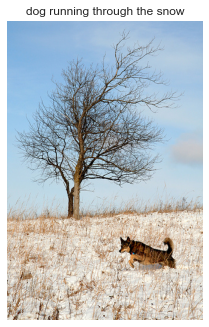

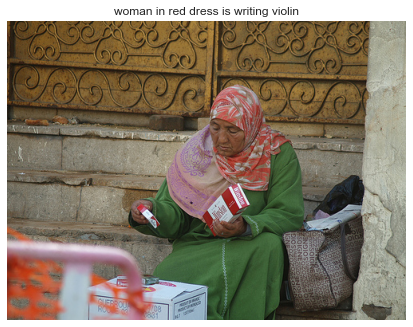

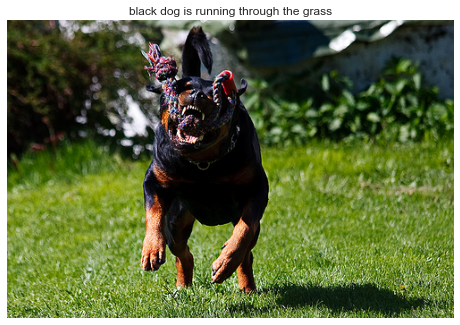

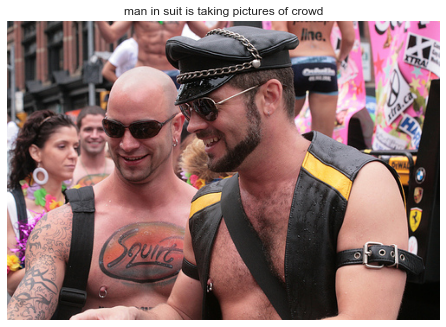

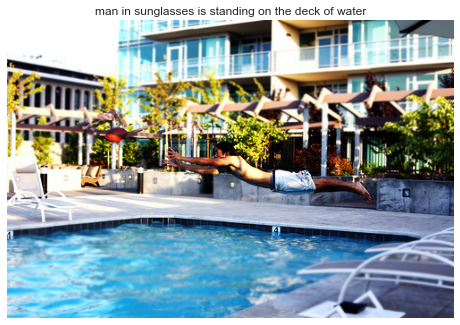

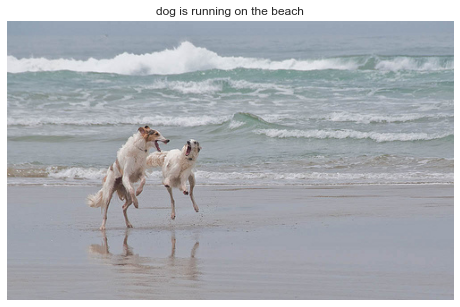

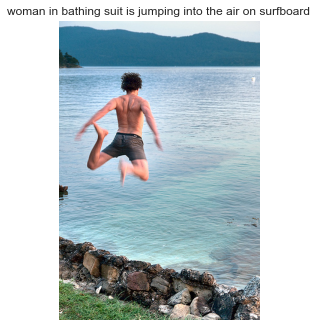

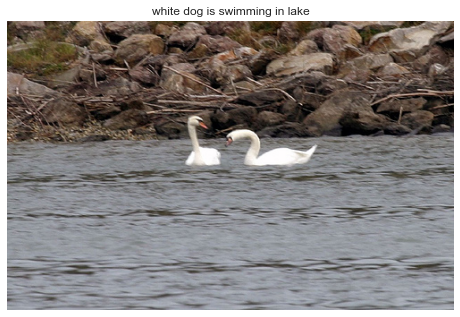

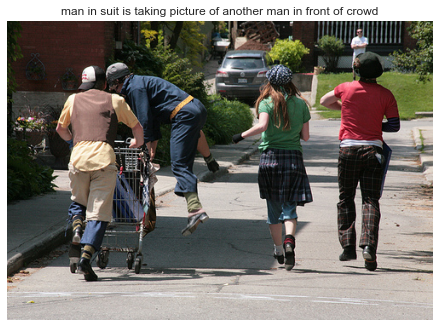

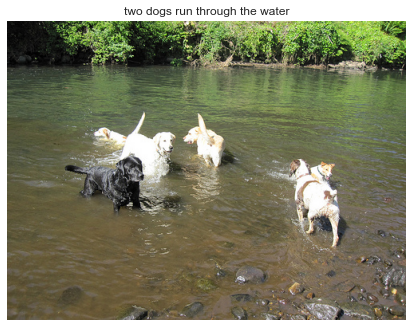

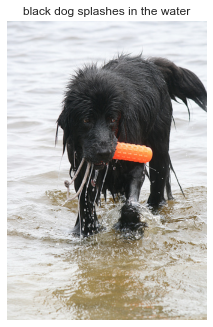

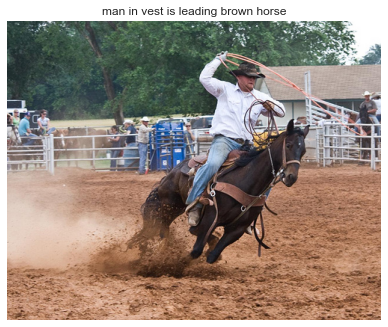

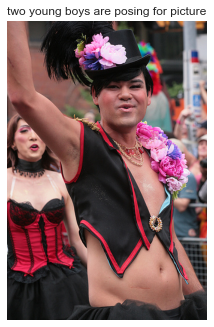

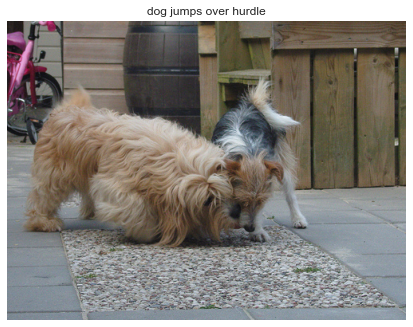

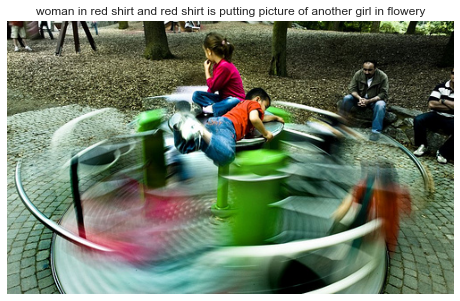

In [54]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = test[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./archive (1)/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()